In [1]:
import numpy as np
from collections import Counter

# **Random Forest Classifier**

In [2]:
# Decision Tree Node
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [3]:
#decision tree classifier 
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split
                or n_samples == 0):  # Check if no samples are left
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # weighted avg child entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # return information gain
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        if len(y) == 0:  # Check for empty y
            return None
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [4]:
# Random Forest Classifier
class RandomForest:
    def __init__(self, n_trees=100, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth, n_feats=self.n_feats)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [self._most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [5]:

# Helper function to calculate entropy
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum(np.fromiter((p * np.log2(p) for p in ps if p > 0), dtype=float))

In [13]:
import numpy as np
import pandas as pd

In [14]:
# Assuming 'data' is your DataFrame
data = pd.read_csv('/Users/grohan/Documents/archive 2/2020/heart_2020_cleaned.csv')
# data = data.head(1000)



In [22]:
data.columns
data.describe

<bound method NDFrame.describe of     HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0             No -1.902797        1                0       0       -0.178819   
1             No -1.334008        0                0       1       -0.509150   
2             No -0.385011        1                0       0        1.693056   
3             No -0.745447        0                0       0       -0.509150   
4             No -0.821489        0                0       0        2.573939   
..           ...       ...      ...              ...     ...             ...   
995           No -0.124950        1                0       0        0.591953   
996           No -0.520365        1                0       0       -0.509150   
997          Yes -0.322657        0                0       0       -0.399040   
998           No  2.308374        0                0       0        2.794160   
999           No -0.499073        0                0       0       -0.509150   

     

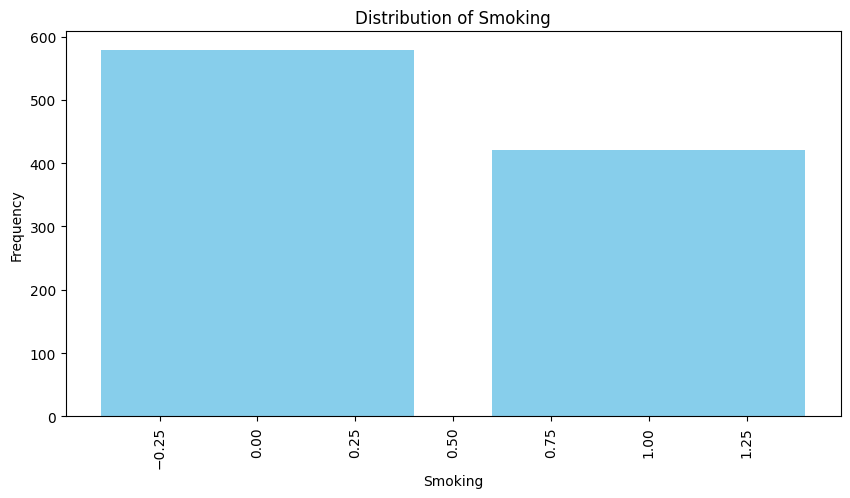

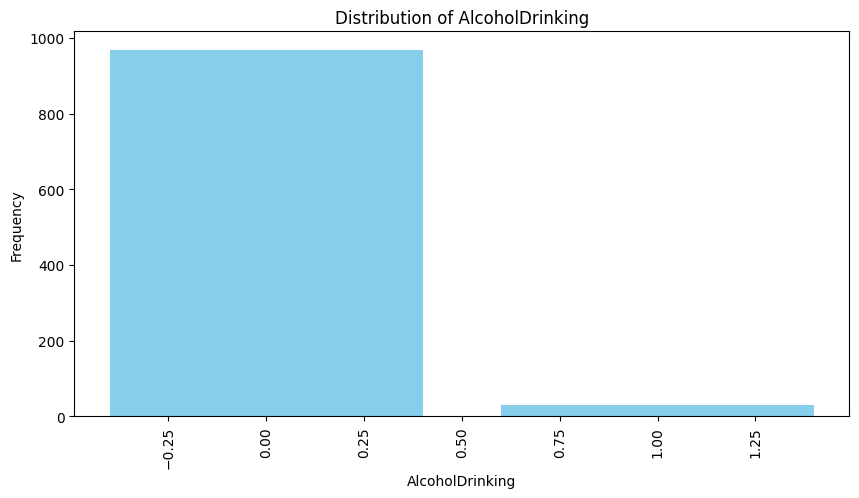

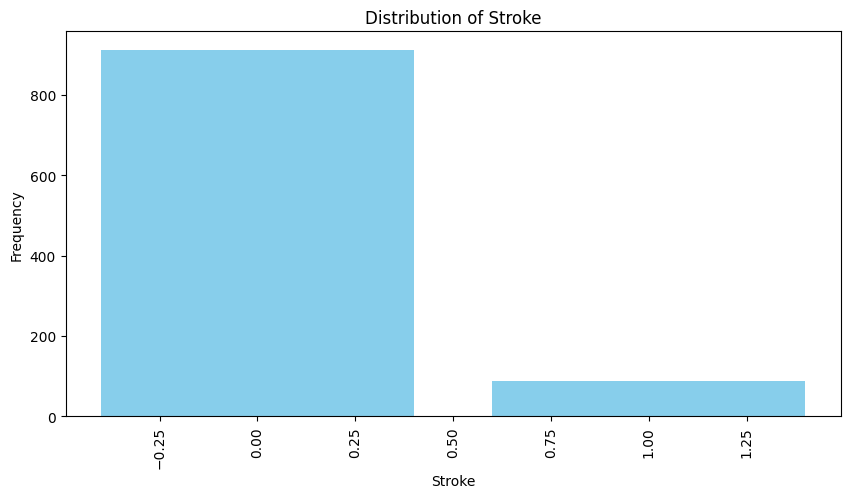

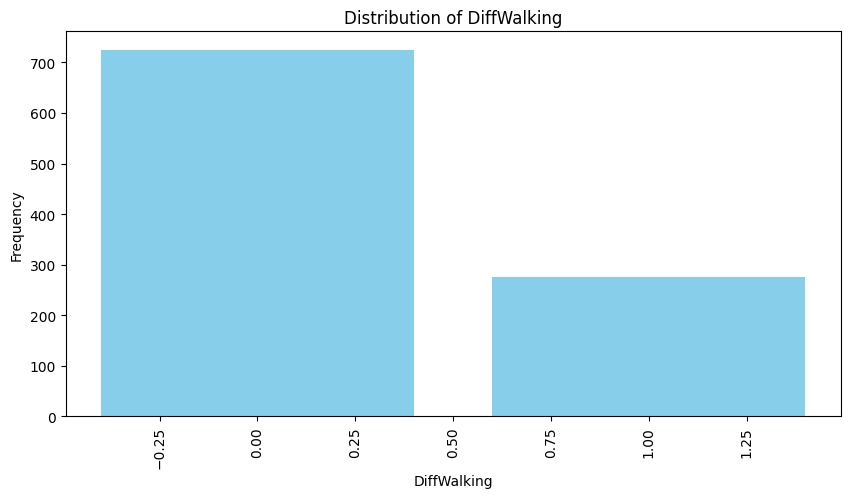

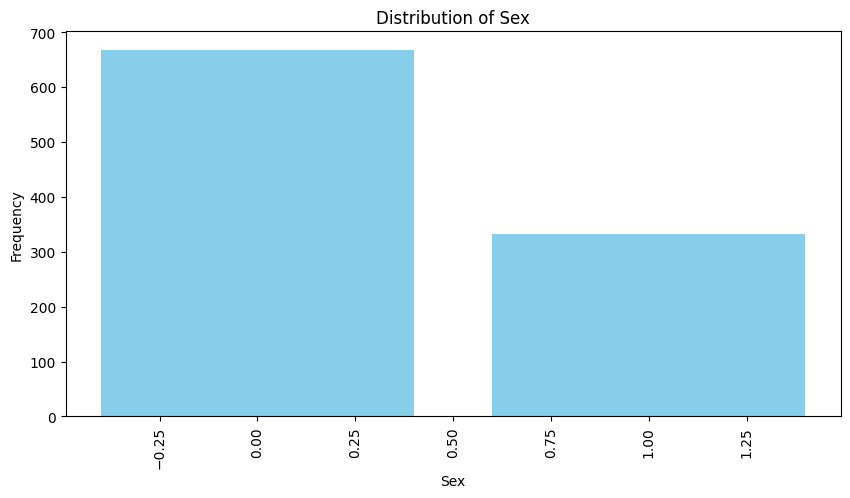

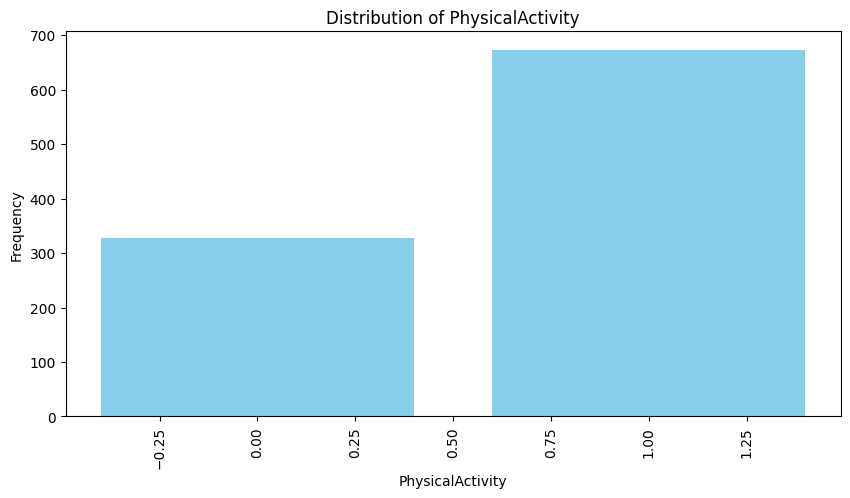

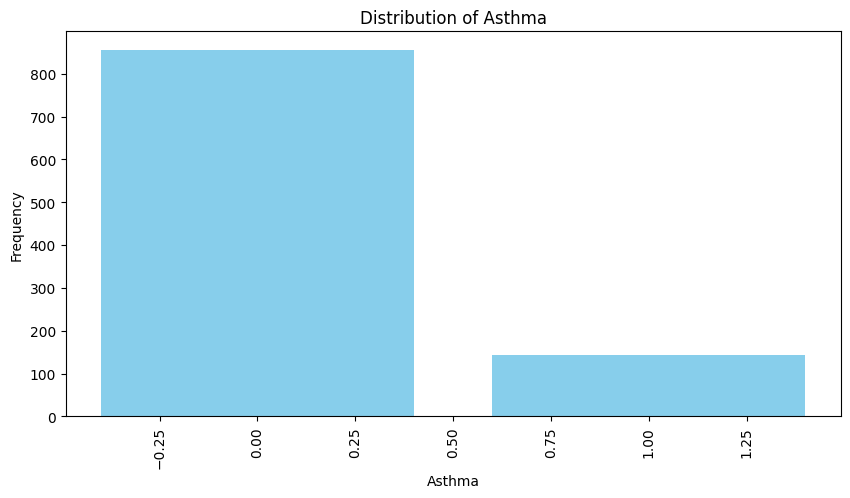

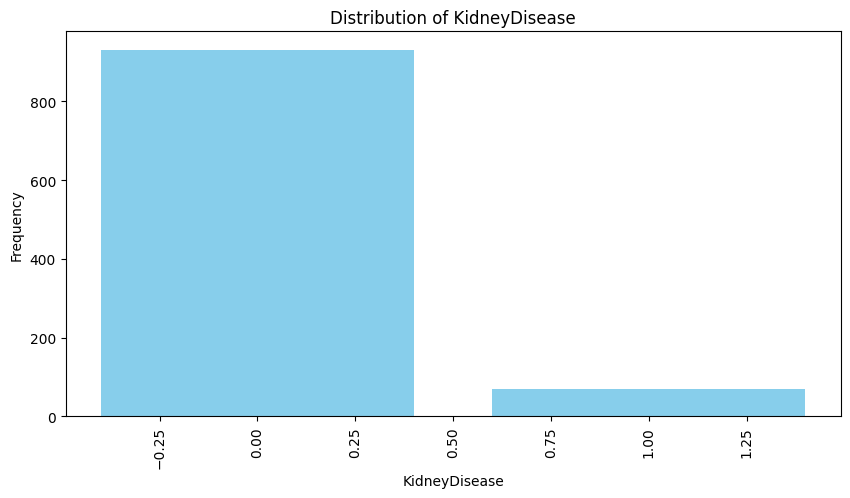

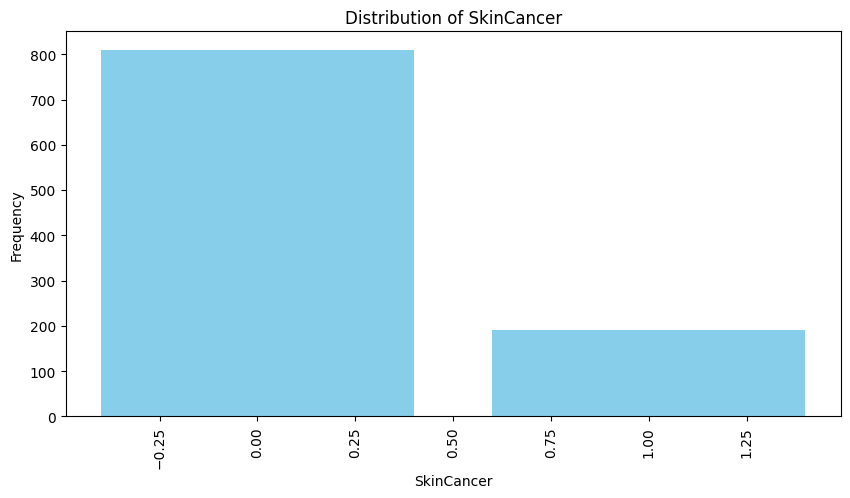

In [23]:
import matplotlib.pyplot as plt
# List of categorical columns
categorical_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

# Plotting the distribution of each categorical variable
for col in categorical_cols:
    # Count the frequency of each category
    value_counts = data[col].value_counts()

    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(value_counts.index, value_counts.values, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the x labels so they don't overlap
    plt.show()

           Variable       Chi2       p-value
3       DiffWalking  50.634470  1.112735e-12
2            Stroke  43.732176  3.765301e-11
7     KidneyDisease  24.075959  9.260933e-07
0           Smoking  12.709420  3.638183e-04
5  PhysicalActivity  11.641601  6.449306e-04
8        SkinCancer   3.091568  7.869894e-02
4               Sex   2.462885  1.165645e-01
6            Asthma   1.431406  2.315351e-01
1   AlcoholDrinking   0.008507  9.265117e-01


/var/folders/85/m_kvgwy534l4g5drq7dm1p8h0000gn/T/ipykernel_59768/792131677.py:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f")


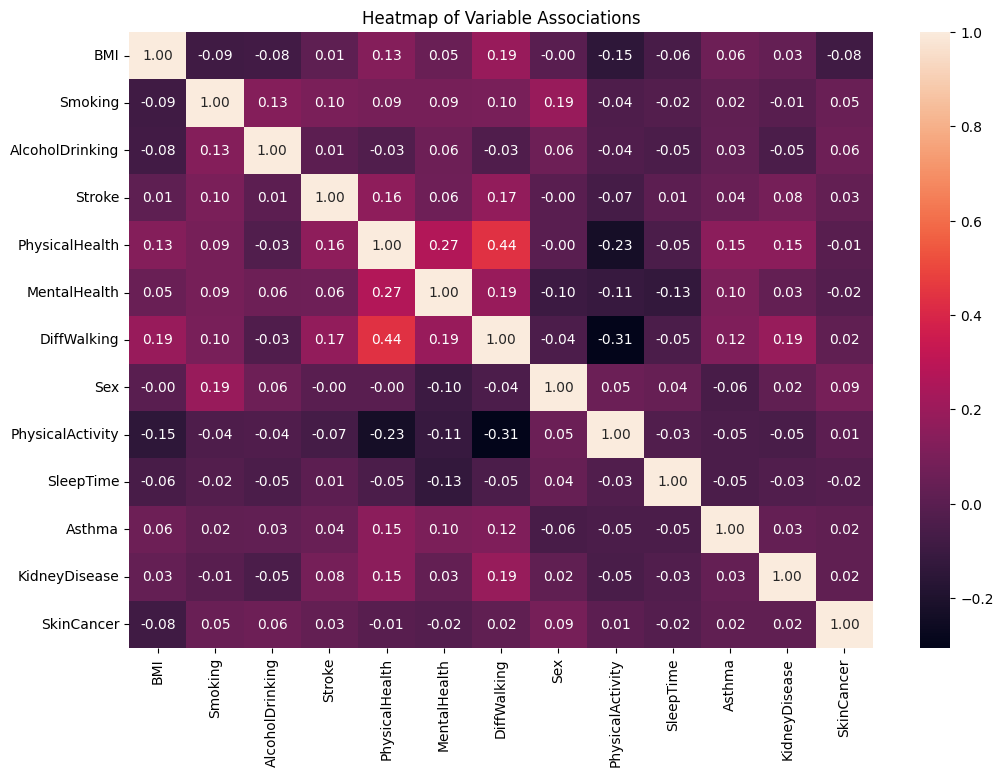

In [24]:
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns
categorical_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

# Initialize a list to store chi-squared test results
chi_squared_results = []

# Perform Chi-squared test between each categorical variable and 'HeartDisease'
for col in categorical_cols:
    contingency_table = pd.crosstab(data['HeartDisease'], data[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_squared_results.append((col, chi2, p))

# Convert the results to a DataFrame and sort by the p-value
chi_squared_df = pd.DataFrame(chi_squared_results, columns=['Variable', 'Chi2', 'p-value'])
chi_squared_df = chi_squared_df.sort_values(by='p-value')

# Display the results
print(chi_squared_df)

# Visualize the associations with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Heatmap of Variable Associations')
plt.show()

In [15]:
# Manual Label Encoding
categorical_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes

# Dropping certain columns
data = data.drop(['AgeCategory', 'Race', 'Diabetic', 'GenHealth'], axis=1)


In [16]:
# Splitting the data
def train_test_split(data, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(data))

    indices = data.index.tolist()
    test_indices = np.random.choice(indices, size=test_size, replace=False)

    test_data = data.loc[test_indices]
    train_data = data.drop(test_indices)
    
    return train_data, test_data

# Manual Feature Scaling
def scale_data(data):
    for column in data.columns:
        if data[column].dtype == 'int64' or data[column].dtype == 'float64':
            data[column] = (data[column] - data[column].mean()) / data[column].std()
    return data

In [17]:
# Preparing the data
data = scale_data(data)
train_data, test_data = train_test_split(data, test_size=0.3)

X_train = train_data.drop('HeartDisease', axis=1).values
y_train = train_data['HeartDisease'].values
X_test = test_data.drop('HeartDisease', axis=1).values
y_test = test_data['HeartDisease'].values

y_train = np.where(y_train == 'Yes', 1, 0)
y_test = np.where(y_test == 'Yes', 1, 0)

In [18]:
# Training the Custom Random Forest
custom_rf = RandomForest(n_trees=100, max_depth=100, n_feats=None)
custom_rf.fit(X_train, y_train)

# Making Predictions
y_pred = custom_rf.predict(X_test)

In [21]:
# Evaluating the Model
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Function to calculate precision
def precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    return precision

# Function to calculate recall
def recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    return recall

# Function to calculate F1 score
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1



accuracy_val = accuracy(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy_val}')
print(f'F1 Score: {f1_val}')


Accuracy: 0.8366666666666667
F1 Score: 0.5967213114754099
